# Tutorial 9: Multitable 


In this tutorial, we will execute the avatarization of a multi-table dataset. If you want to know more about how the anonymization is performed, you can read [this page](https://docs.octopize.io/docs/understanding/multi_table/).


### Setup

In [10]:
import numpy as np
import pandas as pd
import io

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import os

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

# This is the client that you'll be using for all of your requests
from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate, BasePrivacyMetricsParameters
from avatars.models import ReportCreate,SignalMetricsJobCreate,SignalMetricsParameters
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters, PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters,BasePrivacyMetricsParameters,BaseAvatarizationParameters

# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

{'message': 'ok'}

## Loading data

In this tutorial, we will avatarise data that contains a patient table, a doctor table and a visit table 
- There are 130 patients having at least 1 visit
- There are 50 doctors, they all did at least one visit 
- There are 300 visits

Note: 
- Each table has a primary key with only unique values
- Each child table refers to a parent table using a foreign key

<img src="img/multitable.png" style="height:500px" />

In [11]:
doctor = pd.read_csv("../fixtures/doctor.csv", sep=",")
patient = pd.read_csv("../fixtures/patient.csv", sep=",")
visit = pd.read_csv("../fixtures/visit.csv", sep=",")

In [7]:
patient.head()

,patient_id,gender,height,age,weight
0,0,Female,143.548913,72.151503,48.373323
1,1,Female,168.379863,75.245786,64.936355
2,2,Female,163.936152,68.709763,63.023700
3,3,Female,144.498306,69.477118,33.869671
4,4,Female,162.280781,64.343092,45.117277


In [8]:
doctor.head()

,doctor_id,job,age
0,0,pediatrician,36.374378
1,1,pediatrician,34.312795
2,2,pediatrician,40.288084
3,3,pediatrician,44.212885
4,4,pediatrician,38.885413


In [9]:
visit.head()

,visit_id,patient_id,doctor_id,day_visit,exam
0,0,86,29,Tuesday,routine_check
1,1,10,4,Tuesday,pediatrics
2,2,101,37,Wednesday,routine_check
3,3,108,39,Friday,vaccine
4,4,113,40,Wednesday,vaccine


## Upload data
First we need to upload each table in the database.
Each id column name MUST be specified in the `identifier_variables` parameter

Note: 
- A table with no ancestor has only 1 id variable (primary key)
- Any other table has 1 id variable per link with a parent table (foreign key) + its primary key.

In [12]:
dataset_patient = client.pandas_integration.upload_dataframe(
    patient,
    name="patient",
    identifier_variables=[
        "patient_id",
    ],
)

dataset_doctor = client.pandas_integration.upload_dataframe(
    doctor,
    name="doctor",
    identifier_variables=[
        "doctor_id",
    ],
)

dataset_visit = client.pandas_integration.upload_dataframe(
    visit,
    name="visit",
    identifier_variables=["visit_id", "patient_id", "doctor_id"],
)

## Parameters setup
Once the tables have been uploaded, you need to specify which ones are at individual level.

Note:
- An individual level table is a dataframe where each row refers to a UNIQUE physical individual. Privacy metrics assess the re-identification risk of these individuals.
- A table with no ancestor must be at individual level.

In [13]:
patient_ref = TableReference(
    dataset_id=dataset_patient.id,
    is_individual_level=True,
)

doctor_ref = TableReference(
    dataset_id=dataset_doctor.id,
    is_individual_level=True,
)

visit_ref = TableReference(
    dataset_id=dataset_visit.id,
    is_individual_level=False,
)

Finally, before proceeding to anonymization, you need to specify the links between each table, as well as the anonymization parameters for each table.

Note:
- A link is a relation between 1 parent table and 1 child table

In [14]:
table_links = [
    TableLink(
        parent_table=patient_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="p_id",
        child_link_key="patient_id",
    ),
    TableLink(
        parent_table=doctor_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="d_id",
        child_link_key="doctor_id",
    ),
]

# The k parameter for each table needs to be adjusted regarding the number of records.
avat_parameters = [
        BaseAvatarizationParameters(dataset_id=dataset_patient.id, k=15),
        BaseAvatarizationParameters(dataset_id=dataset_doctor.id, k=5),
        BaseAvatarizationParameters(dataset_id=dataset_visit.id, k=30),
]

## Anonymization

In [16]:

avat_job = client.jobs.create_avatarization_multi_table_job(
    AvatarizationMultiTableJobCreate(
        parameters=AvatarizationMultiTableParameters(
            table_links=table_links, table_parameters=avat_parameters
        )
    )
)

avat_job = client.jobs.get_avatarization_multi_table_job(avat_job.id, timeout=100)
results = avat_job.result.datasets

# Get back avatar tables from the results

#Patient
patient_avatar_id = results[0].avatars_dataset.id
patient_avatar = client.pandas_integration.download_dataframe(
    patient_avatar_id
)
# Doctor
doctor_avatar_id = results[1].avatars_dataset.id
doctor_avatar = client.pandas_integration.download_dataframe(
    doctor_avatar_id
)

# Visit
visit_avatar_id = results[2].avatars_dataset.id
visit_avatar = client.pandas_integration.download_dataframe(
    visit_avatar_id
)



    

Exception: Got error in HTTP request: GET http://localhost:8000/jobs/avatarization_multi_table/ada3d413-d839-46a6-bfa0-825880582491. Error status 500 - Internal error

In [9]:
patient_avatar.head()

,patient_id,gender,height,age,weight
0,63,Male,174.459209,58.618585,77.792294
1,2,Female,158.604853,70.634273,54.354494
2,113,Female,165.609125,73.212405,64.615591
3,23,Male,174.476361,58.052777,85.244750
4,6,Male,178.651282,57.905450,91.197006
...,...,...,...,...,...
145,80,Female,159.147449,66.149807,61.556504
146,83,Male,171.622970,55.132012,65.033583
147,50,Female,173.298639,75.631914,68.790889
148,134,Female,162.493978,73.221278,64.537042


In [10]:
doctor_avatar.head()

,doctor_id,job,age
0,42,general practitioner,55.567256
1,19,general practitioner,56.712057
2,28,general practitioner,59.483093
3,5,general practitioner,60.074425
4,31,general practitioner,61.145396
5,11,pediatrician,46.941840
6,40,general practitioner,56.628599
7,44,general practitioner,55.412140
8,13,pediatrician,46.239823
9,8,general practitioner,50.779121


In [11]:

visit_avatar.head()

,visit_id,patient_id,doctor_id,day_visit,exam
0,183,1,38,Thursday,vaccine
1,289,1,7,Monday,routine_check
2,112,1,40,Thursday,pediatrics
3,133,2,47,Thursday,routine_check
4,55,2,44,Monday,vaccine
...,...,...,...,...,...
295,250,147,3,Thursday,routine_check
296,189,147,17,Thursday,routine_check
297,165,147,27,Thursday,routine_check
298,272,147,24,Thursday,routine_check


## Privacy metric computation
Similarly to multitable avatarization, privacy metrics calculation requires the specification of one set of parameter per table. 

In [12]:
privacy_parameters = parameters = [
    BasePrivacyMetricsParameters(
        original_id=results[0].original_dataset_id,
        unshuffled_avatars_id=results[0].sensitive_unshuffled_avatars_datasets.id,
        closest_rate_percentage_threshold=0.3,
        closest_rate_ratio_threshold=0.3,
        known_variables=[
            "gender",
            "age",
        ],
        target="weight",
    ),
    BasePrivacyMetricsParameters(
        original_id=results[1].original_dataset_id,
        unshuffled_avatars_id=results[1].sensitive_unshuffled_avatars_datasets.id,
        closest_rate_percentage_threshold=0.3,
        closest_rate_ratio_threshold=0.3,
        known_variables=[
            "age",
        ],
        target="job",
    ),
    BasePrivacyMetricsParameters(
        original_id=results[2].original_dataset_id,
        unshuffled_avatars_id=results[2].sensitive_unshuffled_avatars_datasets.id,
    ),
]

privacy_job = client.jobs.create_privacy_metrics_multi_table_job(
    PrivacyMetricsMultiTableJobCreate(
        parameters=PrivacyMetricsMultiTableParameters(
            table_links=table_links,
            table_parameters=privacy_parameters,
        )
    )
)

privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id, timeout=1000)


## Privacy metric results
The privacy metrics results are computed on multiple tables to verify as many attack scenario as possible.

We define 4 types of multi table privacy scenario. For each scenario, we compute the same privacy metrics used with tabular data and further described [here](https://docs.octopize.io/docs/understanding/Privacy) by comparing orginal to avatars.

1. **STANDALONE**:
    Privacy metrics are applied on original unmodified tables. (patient and doctor in our example) 

2. **TO_TOP_ENRICHED**:
    Privacy metrics are applied on individual level tables (patient and doctor) enriched with aggregated information from all successor tables (visit).
    
3. **TO_BOTTOM_ID_PROPAGATED**:
    Privacy metrics are applied on all successor of each individual table. The evaluation is done by propagating the individual id of each individual table (patient.p_id or doctor.d_id) to all successor tables (only visit in our example).

4. **FULL_ENRICHED**:
    Privacy metrics are applied on direct successors of an individual table (only visit in our example). The evaluation is done by enriching the successor table (visit) with all the variables of an individual-level parent table (patient or doctor) and with aggregated information from successor tables (None here as visit has no successor).



<img src="img/multitable_privacy.png" style="height:500px" />

## RAW results

In [13]:
privacy_metrics = privacy_job.result.details
print("*** Privacy metrics ***")
for metric in privacy_metrics:
    print('--------')
    print(metric)

*** Privacy metrics ***
--------
hidden_rate=82.0 local_cloaking=2.0 distance_to_closest=0.01497 closest_distances_ratio=0.4396 column_direct_match_protection=96.0 categorical_hidden_rate=100.0 row_direct_match_protection=100.0 correlation_protection_rate=None inference_continuous=None inference_categorical=None closest_rate=None targets=PrivacyMetricsTargets(hidden_rate='> 90', local_cloaking='> 5', distance_to_closest='> 0.2', closest_distances_ratio='> 0.3', column_direct_match_protection='> 50', categorical_hidden_rate='> 90', row_direct_match_protection='> 90', correlation_protection_rate='> 95', inference_continuous='> 10', inference_categorical='> 10', closest_rate='> 90') original_id=UUID('3c8a2806-fa07-464c-9885-72e23045d322') unshuffled_avatars_id=UUID('38a9495b-dc02-48a7-a365-d98185023da9') metrics_type='multi_table' individual_identifier_variable='doctor.doctor_id' computation_type=<PrivacyMetricsComputationType.standalone: 'standalone'> dataset_name='doctor'
--------
hidde

## Summary table

In [ ]:
index = ['doctor_standalone', 'patient_standalone', 
                      'visit_to_bottom_id_propagated_doctor.doctor_id', 'visit_to_bottom_id_propagated_patient.patient_id',
                      'doctor_to_top_enriched_doctor.doctor_id', 'patient_to_top_enriched_patient.patient_id',
                      'visit_full_enriched_doctor.doctor_id','visit_full_enriched_patient.patient_id']
privacy_job
data=privacy_job.result.details
data_dict = {
    'Hidden Rate': [round(d.hidden_rate,2) for d in data],
    'Local Cloaking': [round(d.local_cloaking,2) for d in data],
    'Distance to Closest': [round(d.distance_to_closest,4) for d in data],
    'Closest Distances Ratio': [round(d.closest_distances_ratio,4) for d in data],
    'Column Direct Match Protection': [round(d.column_direct_match_protection,2) for d in data],
    'Categorical Hidden Rate': [round(d.categorical_hidden_rate,2) for d in data],
    'Row Direct Match Protection': [round(d.row_direct_match_protection,2) for d in data],
    'Table': [d.dataset_name + "_" + d.computation_type.name + ("_" + d.individual_identifier_variable if d.computation_type.name !="standalone" else "") for d in data], 
 }

summary_table = pd.DataFrame(data_dict)
summary_table.set_index('Table', inplace=True)
summary_table= summary_table.reindex(index)
summary_table.loc['TARGET',:]=[
    metric.targets.hidden_rate,
    metric.targets.local_cloaking,
    metric.targets.distance_to_closest,
    metric.targets.closest_distances_ratio,
    metric.targets.column_direct_match_protection,
    metric.targets.categorical_hidden_rate,
    metric.targets.row_direct_match_protection
]

In [15]:
summary_table

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
doctor_standalone,82.00,2.0,0.0150,0.4396,96.00,100.00,100.0
patient_standalone,84.00,2.0,0.1550,0.6437,98.67,100.00,100.0
visit_to_bottom_id_propagated_doctor.doctor_id,100.00,28.0,0.0000,1.0000,98.38,100.00,0.0
visit_to_bottom_id_propagated_patient.patient_id,100.00,36.0,0.0000,1.0000,98.38,100.00,0.0
doctor_to_top_enriched_doctor.doctor_id,80.00,8.0,0.4059,0.5315,95.60,66.67,100.0
patient_to_top_enriched_patient.patient_id,94.00,26.0,0.4788,0.6701,98.67,100.00,100.0
visit_full_enriched_doctor.doctor_id,92.67,14.0,0.4871,0.7239,98.38,100.00,100.0
visit_full_enriched_patient.patient_id,94.33,30.0,0.4871,0.7239,98.38,100.00,100.0
TARGET,90.00,5.0,0.2000,0.3000,50.00,90.00,90.0


# Utility evaluation

## Univariate comparison 

You can here compare distributions between original and avatar data.  
If distributions are not well preserved, you can work with the parameter `columns_weight` in your avatarization.

### Patient

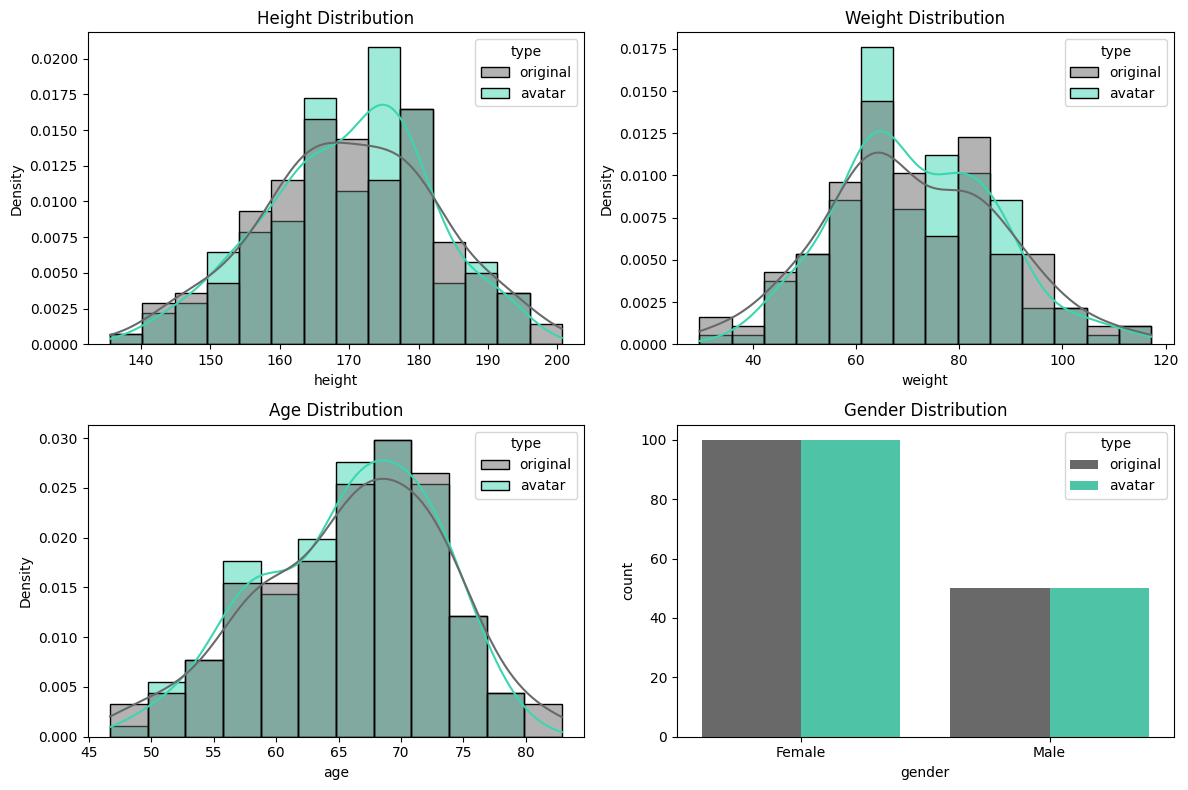

In [16]:
AVATAR_COLOR = '#3BD6B0'
ORIGINAL_COLOR = 'dimgrey'
map_color= {'original':ORIGINAL_COLOR, 'avatar':AVATAR_COLOR}

patient_combined = pd.concat([patient, patient_avatar]).reset_index(drop=True)
patient_combined['type'] = np.repeat(['original', 'avatar'], len(patient))

# Continuous distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=patient_combined, x='height', hue="type", palette=map_color, kde=True, ax=axes[0, 0], stat="density")
sns.histplot(data=patient_combined, x='weight', hue="type", palette=map_color, kde=True, ax=axes[0, 1], stat="density")
sns.histplot(data=patient_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[1, 0], stat="density")

# Categorical distribution
sns.countplot(data=patient_combined, x='gender',hue='type',  palette=map_color, ax=axes[1, 1])

axes[0, 0].set_title('Height Distribution')
axes[0, 1].set_title('Weight Distribution')
axes[1, 0].set_title('Age Distribution')
axes[1, 1].set_title('Gender Distribution')
plt.tight_layout()
plt.show()

### Doctor

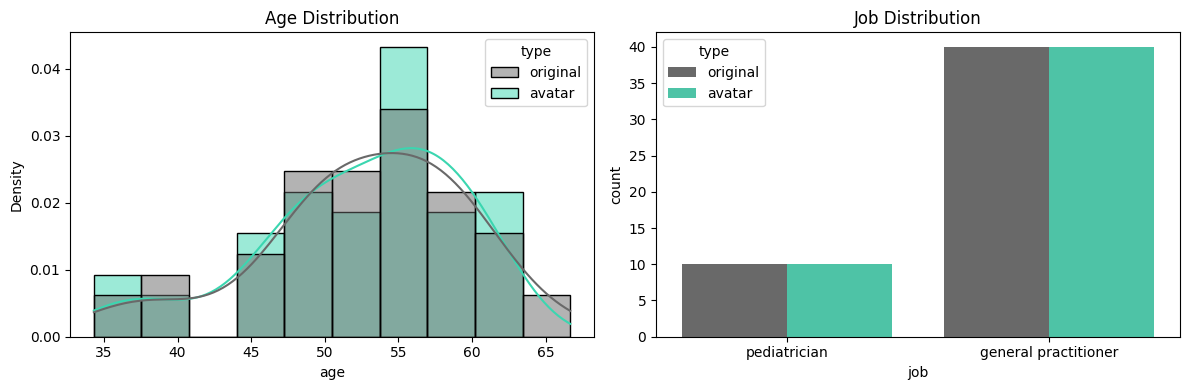

In [17]:
doctor_combined = pd.concat([doctor, doctor_avatar]).reset_index(drop=True)
doctor_combined['type'] = np.repeat(['original', 'avatar'], len(doctor))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Continuous distribution
sns.histplot(data=doctor_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[0], stat="density")

# Categorical distribution
sns.countplot(data=doctor_combined, x='job',hue='type',  palette=map_color, ax=axes[1])

axes[0].set_title('Age Distribution')
axes[1].set_title('Job Distribution')
plt.tight_layout()
plt.show()

### Visit

<Axes: xlabel='exam', ylabel='count'>

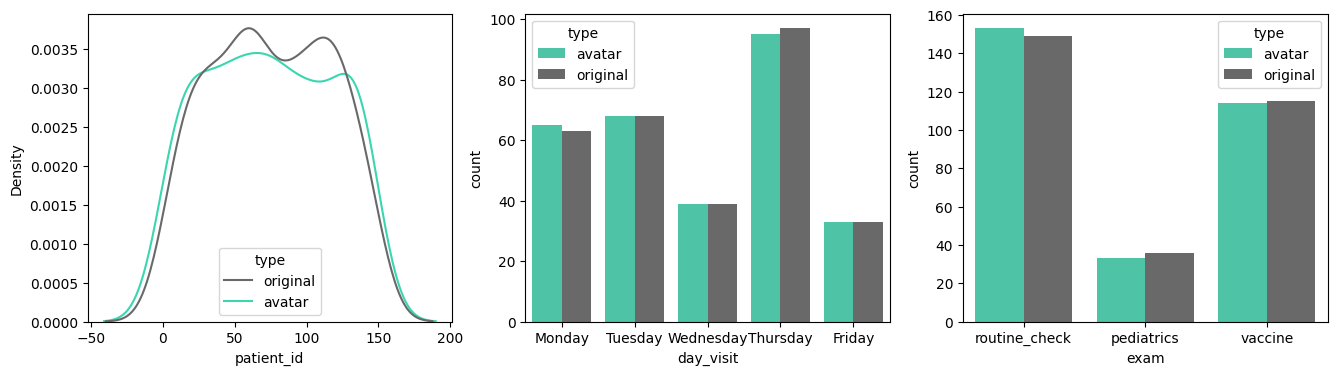

In [18]:
visit_combined = pd.concat([visit, visit_avatar]).reset_index(drop=True)
visit_combined['type'] = np.repeat(['original', 'avatar'], len(visit))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.kdeplot(data=visit_combined, x='patient_id', hue="type", ax=axes[0], palette=map_color)
day_order=list(visit['day_visit'].unique())
visit_combined['day_visit'] = pd.Categorical(visit_combined['day_visit'], categories=day_order, ordered=True)
visit_combined=visit_combined.sort_values('day_visit')
sns.countplot(data=visit_combined, x='day_visit',hue='type',  palette=map_color, ax=axes[1])
sns.countplot(data=visit_combined, x='exam',hue='type',  palette=map_color, ax=axes[2])


## Multivariate comparison 


### Visit x Patient

In [19]:
doctor_avatar_renamed = doctor_avatar.rename(columns={"age": "age_doctor"})
visit_avatar_flat = visit_avatar.join(
        doctor_avatar_renamed.set_index("doctor_id"), on="doctor_id"
    )
visit_avatar_flat = visit_avatar_flat.join(
        patient_avatar.set_index("patient_id"), on="patient_id"
    )


doctor_renamed = doctor.rename(columns={"age": "age_doctor"})
visit_flat = visit.join(
        doctor_renamed.set_index("doctor_id"), on="doctor_id"
    )
visit_flat = visit_flat.join(
        patient.set_index("patient_id"), on="patient_id"
    )



Text(0.5, 1.0, 'Avatar')

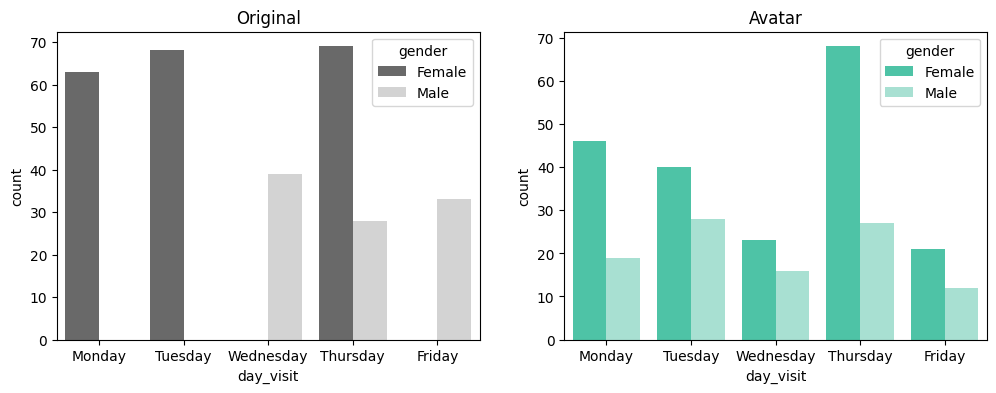

In [20]:
visit_flat['day_visit'] = pd.Categorical(visit_flat['day_visit'], categories=day_order, ordered=True)
visit_flat=visit_flat.sort_values('day_visit')
visit_avatar_flat['day_visit'] = pd.Categorical(visit_avatar_flat['day_visit'], categories=day_order, ordered=True)
visit_avatar_flat=visit_avatar_flat.sort_values('day_visit')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='day_visit',hue="gender",ax=axes[0],palette=[ORIGINAL_COLOR, 'lightgrey'])
sns.countplot(data=visit_avatar_flat,x='day_visit',hue="gender",ax=axes[1],palette=[AVATAR_COLOR, '#9fe9d7'])
axes[0].set_title('Original')
axes[1].set_title('Avatar')

### Visit x Doctor

Text(0.5, 1.0, 'Avatar')

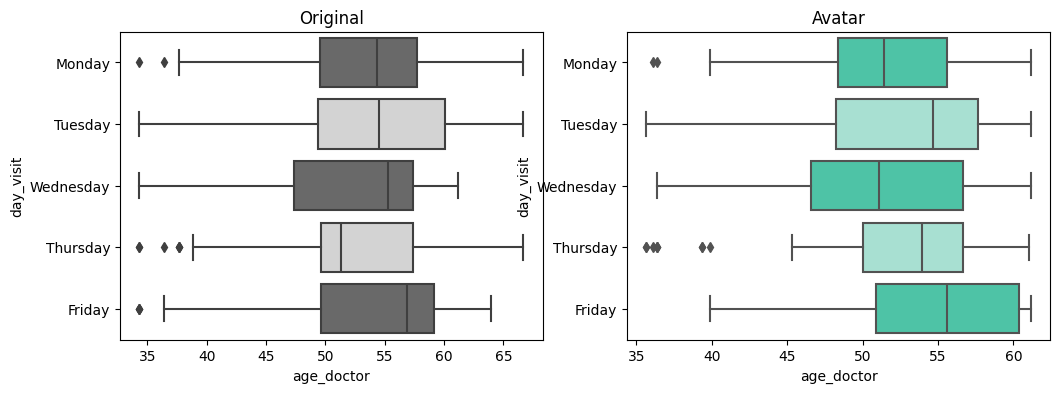

In [21]:
visit_flat['day_visit'] = pd.Categorical(visit_flat['day_visit'], categories=day_order, ordered=True)
visit_flat=visit_flat.sort_values(['day_visit','exam'])
visit_avatar_flat['day_visit'] = pd.Categorical(visit_avatar_flat['day_visit'], categories=day_order, ordered=True)
visit_avatar_flat=visit_avatar_flat.sort_values(['day_visit','exam'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=visit_flat,x='age_doctor',y='day_visit',ax=axes[0],palette=[ORIGINAL_COLOR])
sns.boxplot(data=visit_avatar_flat,x='age_doctor',y='day_visit',ax=axes[1],palette=[AVATAR_COLOR])
axes[0].set_xlim(30, 70)
axes[1].set_xlim(30, 70)
axes[0].set_title('Original')
axes[1].set_title('Avatar')

Text(0.5, 1.0, 'Avatar')

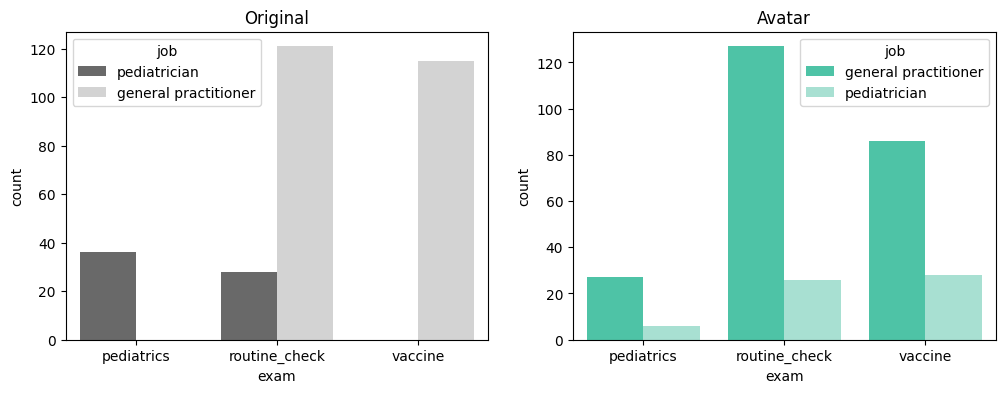

In [22]:
visit_avatar_flat=visit_avatar_flat.sort_values('exam')
visit_flat=visit_flat.sort_values('exam')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='exam',hue="job",ax=axes[0],palette=[ORIGINAL_COLOR, 'lightgrey'])
sns.countplot(data=visit_avatar_flat,x='exam',hue="job",ax=axes[1],palette=[AVATAR_COLOR, '#9fe9d7'])
axes[0].set_title('Original')
axes[1].set_title('Avatar')

### Patient x Doctor

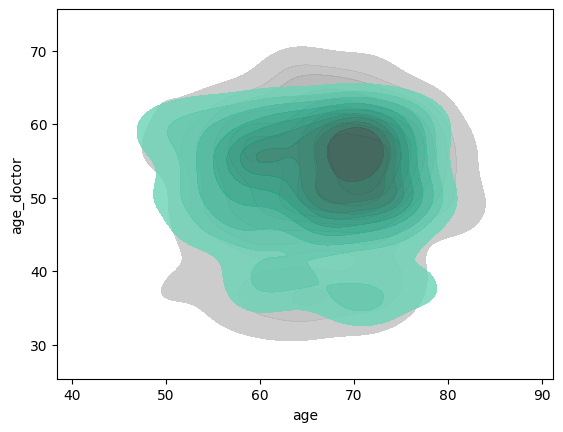

In [23]:
sns.kdeplot(data=visit_flat, x='age', y='age_doctor', fill=True,color=ORIGINAL_COLOR,alpha=0.8)
sns.kdeplot(data=visit_avatar_flat, x='age', y='age_doctor', fill=True,color=AVATAR_COLOR,alpha=0.8)
plt.show()
